In [1]:
import os
import warnings
import numpy as np
import scanpy as sc
import custom_tools
import anndata as ad
import seaborn as sns
import decoupler as dc
from pathlib import Path
from matplotlib import rcParams
import matplotlib.pyplot as plt
from dataset import TissueDataset
from pathlib import Path
import matplotlib


warnings.simplefilter(action='ignore')
sc.settings.verbosity = 0
# Set figure params
sc.set_figure_params(scanpy=True, facecolor="white", dpi=80, dpi_save=300)


In [2]:
# Read json file
# exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
# job_id = "fombnNMthdocYhDPmAjaBQ"
exp_name = "METABRIC"
dataset_name = "METABRIC"
job_id = "9U43MVNB9CQHuwnTN6t0kg"
PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")



# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

# Read the explanations adata
adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/{dataset_name}/{exp_name}_{job_id}_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

# for mod in model.modules():
#    print(mod)

"""

# Read json file
# exp_name = "METABRIC_GATV2_CoxPHLoss_10_fold_gpusaez_14-04-2024"
# job_id = "vuF_GvxYKM6o_m0VUINsMw"
exp_name = "METABRIC"
job_id = "9U43MVNB9CQHuwnTN6t0kg"
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")
# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)


dataset = TissueDataset(os.path.join("../data/METABRIC", "month"),  "month")"""

Seed set to 42
Seed set to 42


GPU is available on this device!
Target prediction: OSmonth


'\n\n# Read json file\n# exp_name = "METABRIC_GATV2_CoxPHLoss_10_fold_gpusaez_14-04-2024"\n# job_id = "vuF_GvxYKM6o_m0VUINsMw"\nexp_name = "METABRIC"\njob_id = "9U43MVNB9CQHuwnTN6t0kg"\ndevice =  custom_tools.get_device()\nargs  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")\n# args["num_node_features"] = 33\ndeg = None\nif "PNA" in exp_name:\n    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")\nmodel = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)\n\n\ndataset = TissueDataset(os.path.join("../data/METABRIC", "month"),  "month")'

In [3]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)

In [4]:
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst= [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    # print(data.tumor_grade)
    tumor_grade_lst.append(str(data.tumor_grade[0]))
    # print(data.is_censored)
    censor_lst.append(data.is_censored[0].item())
embedding_arr.shape

(1078, 256)

In [5]:
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

In [6]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"



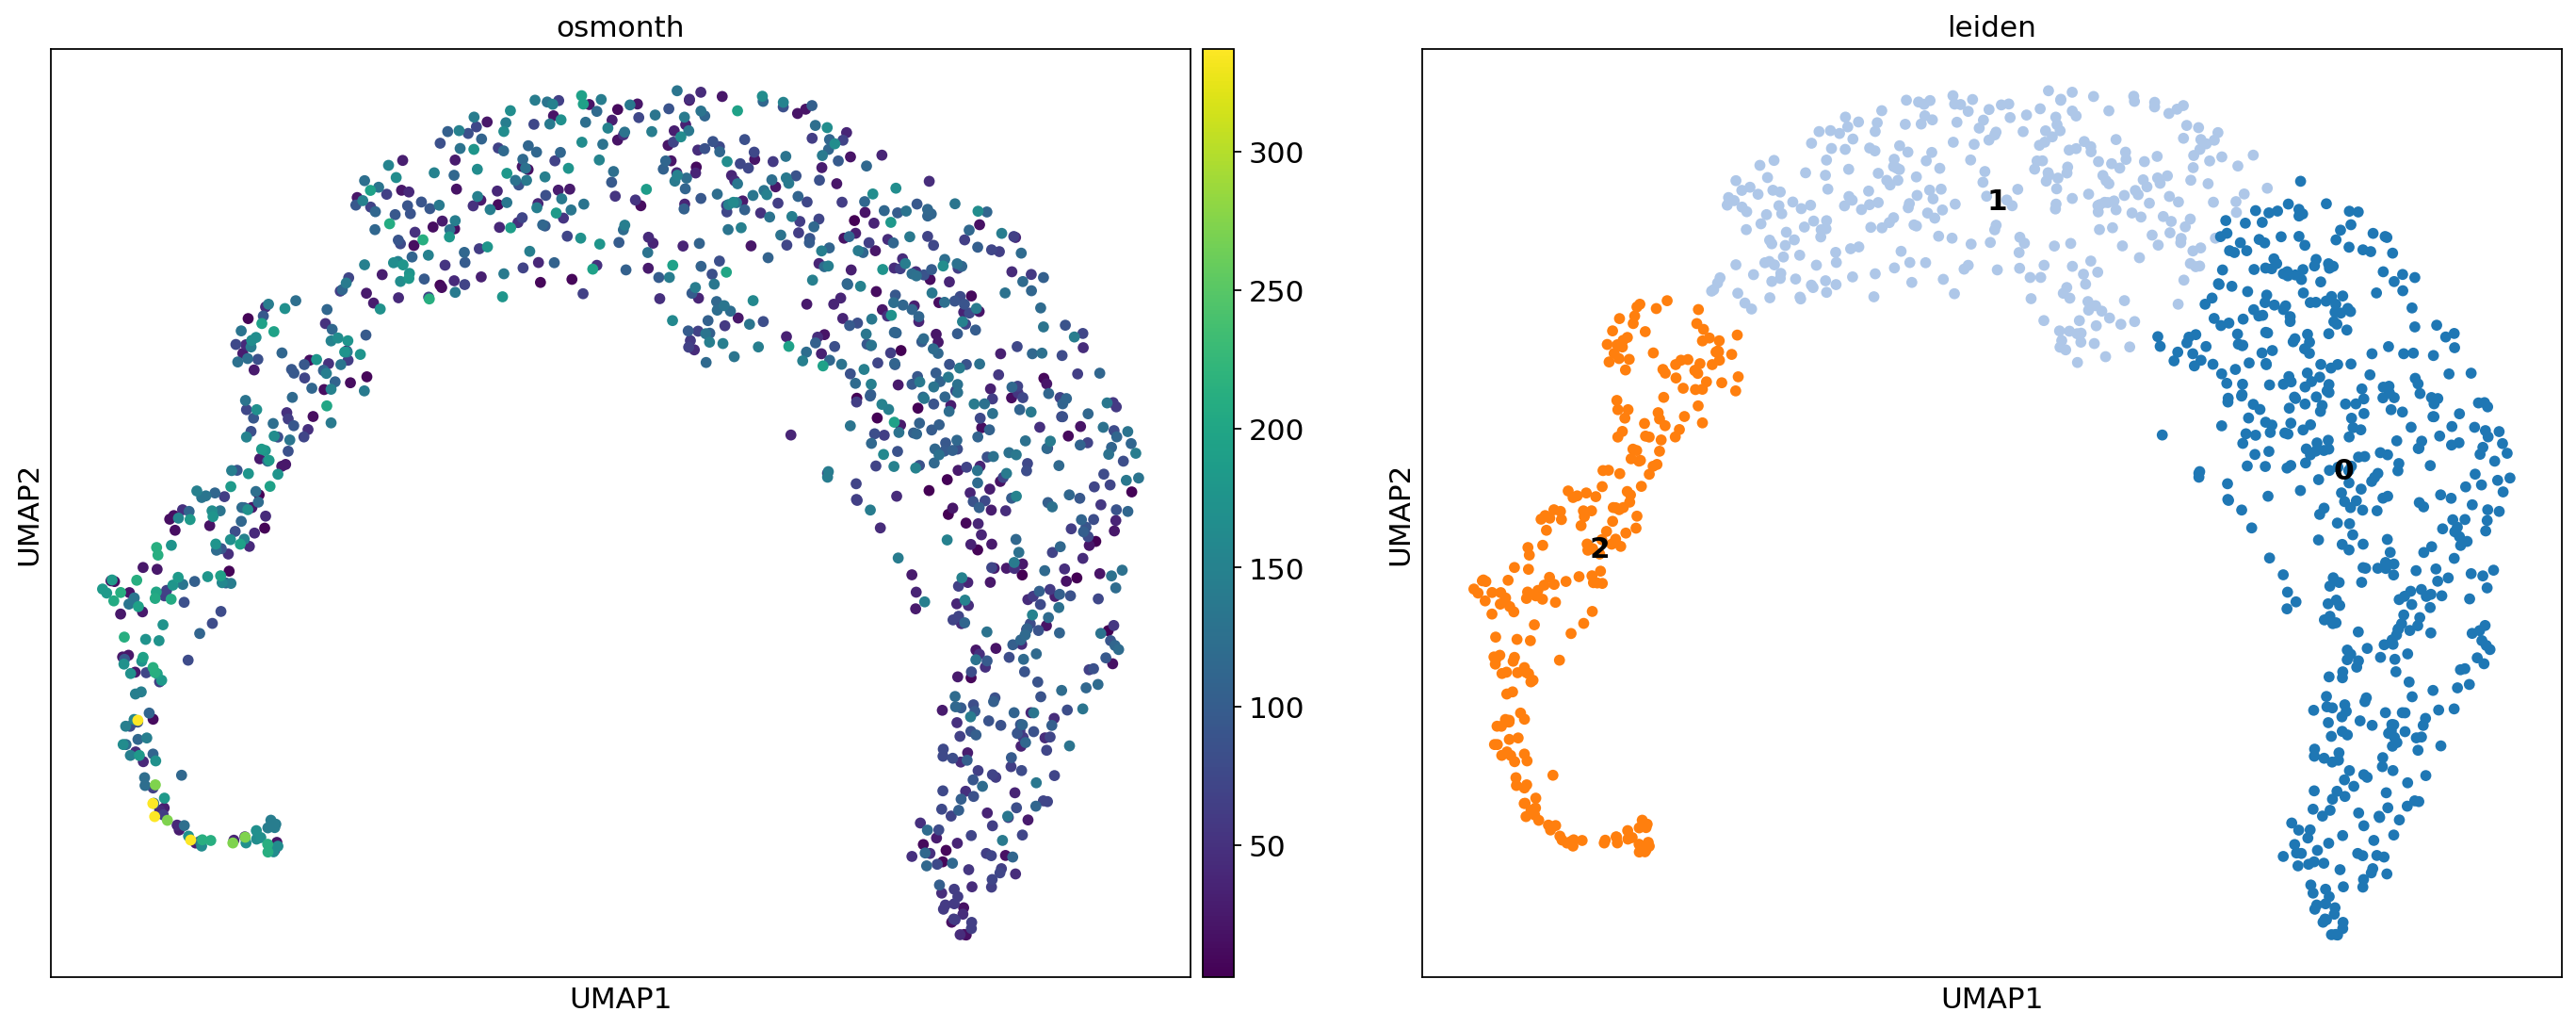

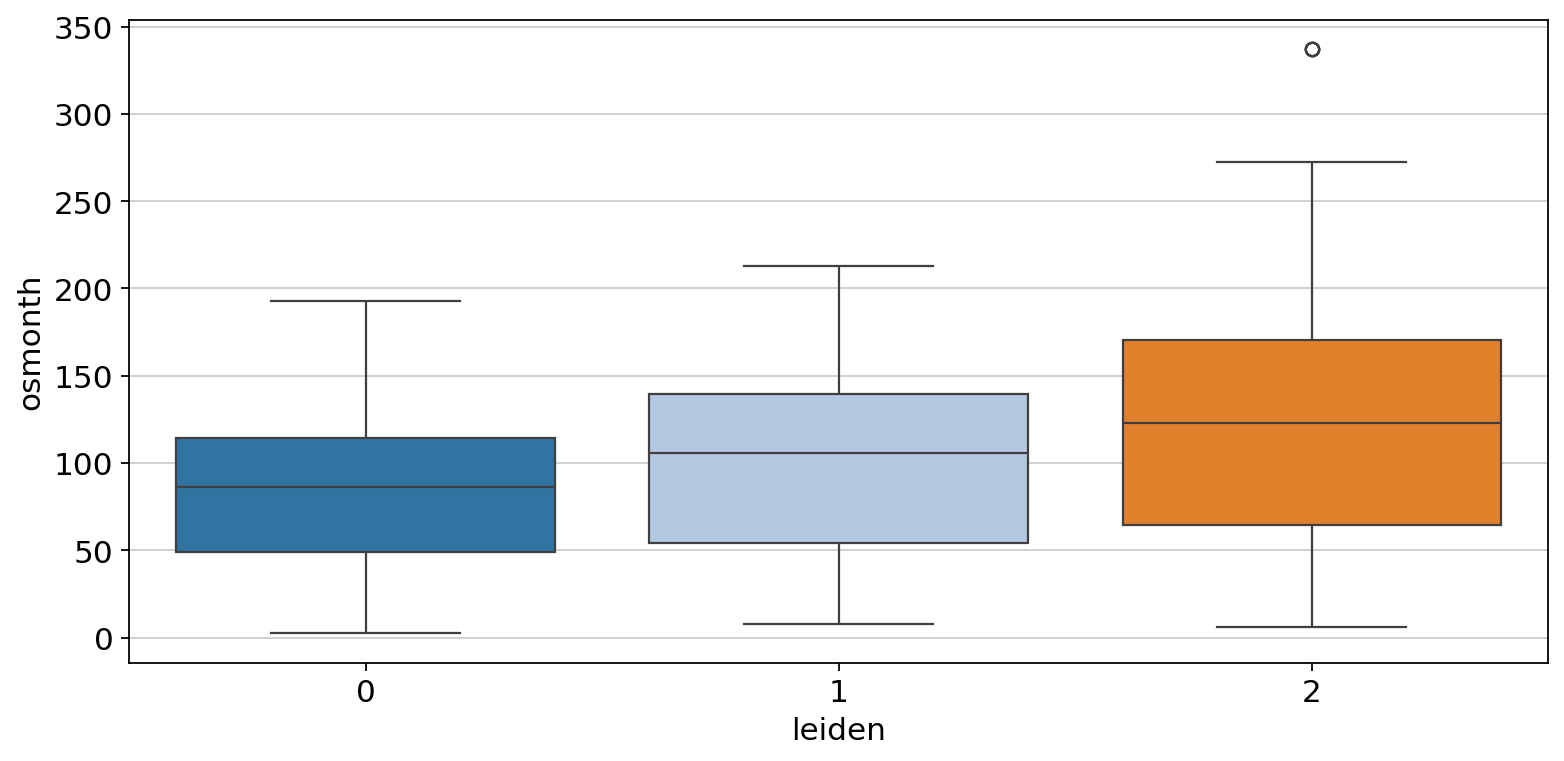

In [7]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb, color=["osmonth", "leiden"], palette=color_dict, show=False, legend_loc = 'on data') #, save="_jacksonfisher_embedding_boxplot.pdf")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_umap.pdf"), dpi=300)


fig = plt.figure(figsize=(10, 5))
sns.boxplot(data=adata_emb.obs, x="leiden", y="osmonth", palette= color_dict)
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_boxplot.pdf"), dpi=300)
# sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
# sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
# sc.pl.umap(adata, color=["is_censored"], palette=["grey", "black"])

# sc.pl.dotplot(adata, n_genes=5, groupby='bulk_labels', dendrogram=True)

# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key=f"t-test", show=True, groupby=f"leiden")

<h2>Create Pseudobulk Profile (Important Nodes)</h2>

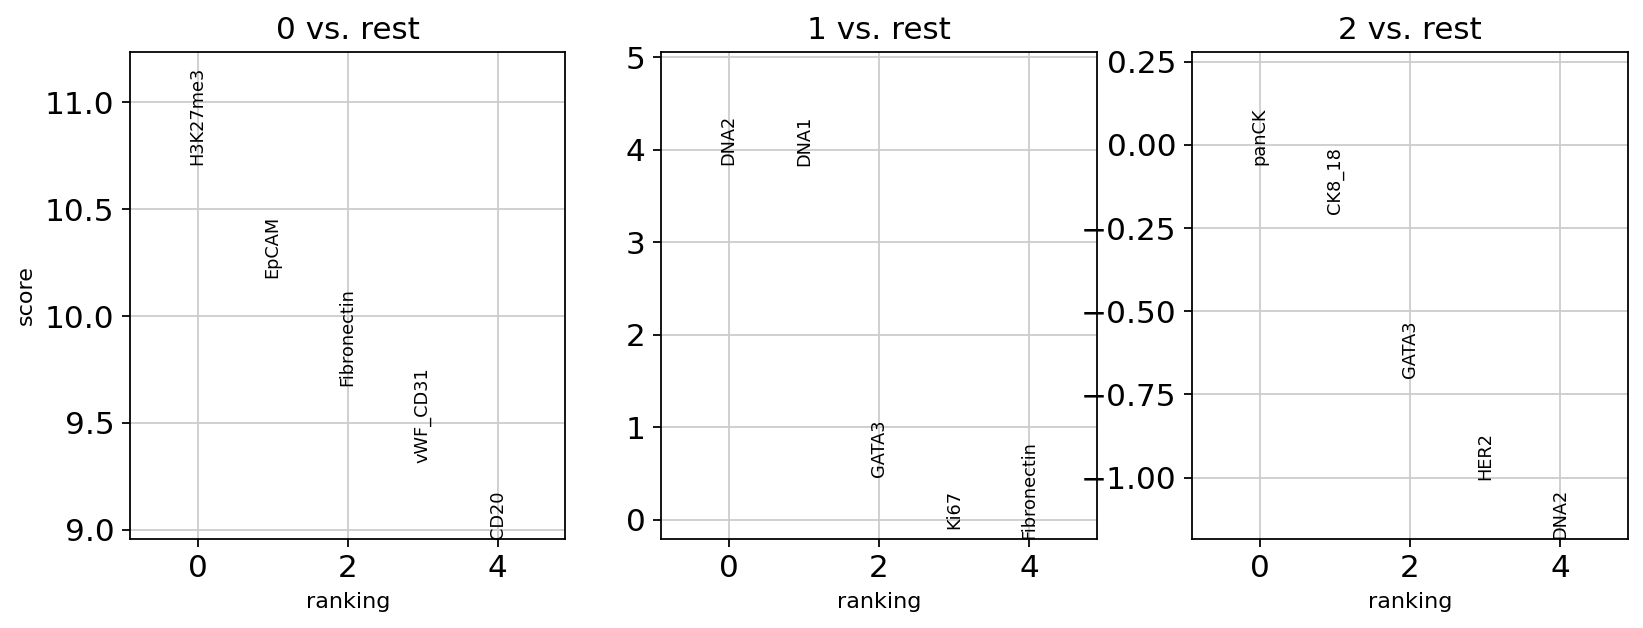

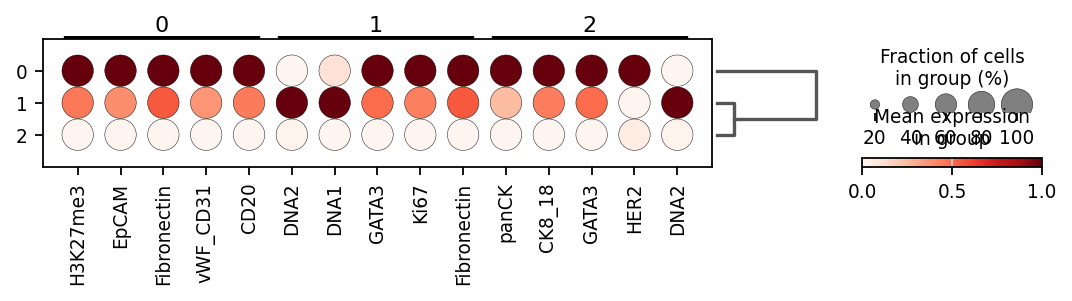

In [11]:
pdata_imp_vs_unimp = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

pdata_imp_vs_unimp.obs_names
pdata_imp = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs_names.str.contains("True"),:].copy()
new_obs_names = [obs_n.split("_")[0] for obs_n in pdata_imp.obs_names]
pdata_imp.obs_names = new_obs_names

pdata_imp.obs["leiden"] = adata_emb.obs["leiden"]
pdata_imp.obsm["X_umap"] = adata_emb.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_imp, groupby=f"leiden", method='wilcoxon', key_added = f"wilcoxon")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
# plt.rcParams.update({'axes.xtick.labelsize' : 'large'})
# plt.rcParams.update({'axes.ytick.labelsize' : 'large'})  
sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon", show=False, groupby="leiden")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)
# plt.rcParams['figure.figsize']=(40,20)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot.pdf"), dpi=300)

In [12]:
# TODO: Add leiden clusters to adta exp

for cat in adata_emb.obs["leiden"].cat.categories:
    img_ids = adata_emb[adata_emb.obs["leiden"]==cat].obs["img_id"].cat.categories
    adata_exp.obs.loc[adata_exp.obs["img_id"].isin(img_ids), "leiden"] = cat

print(sorted(adata_emb[adata_emb.obs["leiden"]=="0"].obs["img_id"].cat.categories))
print(sorted(adata_exp[adata_exp.obs["leiden"]=="0"].obs["img_id"].cat.categories))

adata_exp[adata_exp.obs["img_id"]=="108lr"]

['10', '100', '101ll', '101lr', '101ul', '101ur', '102ll', '102lr', '102ul', '102ur', '107ll', '111ll', '111lr', '111ul', '113', '114', '117ll', '117lr', '117ul', '117ur', '119', '12', '130', '131ll', '132ll', '132lr', '132ul', '132ur', '134', '139', '13ll', '13ur', '14', '141ll', '141lr', '143ll', '143lr', '143ul', '143ur', '146', '147', '153', '154ll', '154lr', '154ul', '154ur', '155lr', '155ul', '155ur', '16', '161ur', '169ll', '169lr', '169ul', '169ur', '17', '170ll', '170ul', '170ur', '175ll', '175lr', '175ul', '175ur', '177lr', '177ur', '181', '184ll', '184lr', '184ul', '184ur', '190ll', '190lr', '190ul', '190ur', '191ll', '191lr', '191ul', '191ur', '193lr', '194', '196', '197', '199ll', '199lr', '199ul', '199ur', '19ll', '19lr', '19ur', '1ll', '1lr', '1ur', '200', '201ll', '201ur', '204ur', '205', '208lr', '208ul', '208ur', '20ll', '20lr', '20ul', '20ur', '212ll', '212ul', '212ur', '213', '215ll', '215lr', '215ul', '215ur', '217', '221', '222ll', '222lr', '222ul', '222ur', '223'

View of AnnData object with n_obs × n_vars = 225 × 39
    obs: 'clinical_type', 'img_id', 'p_id', 'tumor_grade', 'osmonth', 'importance', 'importance_hard', 'cell_type', 'class', 'leiden'
    obsm: 'pos'

In [13]:
def plot_cell_type_proportion(adata, group_col="leiden", obs_col = "cell_type"):
    group_list = list(adata.obs[group_col].cat.categories)
    c_type_list = list(adata.obs[obs_col].cat.categories)
    # print(len(c_type_list))
    #c_type_list.remove("Large elongated")
    #c_type_list.remove("Macrohage")
    if obs_col=="cell_type":
        c_type_list.remove("Macrophage")
    print(len(c_type_list))
    c_type_list = c_type_list[:20]
    for cond in group_list:
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        for c_type in c_type_list:
            if adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]<8:
                print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
                c_type_list.remove(c_type)
            # print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
            # cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/adata_tmp.shape[0]))
    print(c_type_list)
    
    cond_prop = dict()
    cond_arr = []
    for cond in group_list:
        cond_arr.append([])
        # print(cond, cond_arr)
        cond_prop[cond] = []
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        # print(adata_tmp.shape)
        sum = 0
        for c_type in c_type_list:
            # print("c_type", c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape)
            cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/(adata_tmp[adata_tmp.obs[obs_col].isin(c_type_list),:].shape[0])))

    data = np.array(cond_arr).T
    # print("data", data.shape)
    # print(data)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # cmap = matplotlib.cm.get_cmap('tab20')
    # print(cmap.colors)

    X = np.arange(data.shape[1])
    
    for i in range(data.shape[0]):
        ax1.bar(X, data[i],bottom = np.sum(data[:i], 
                    axis =0), width= 0.85, color = cmap.colors[i], label=c_type_list[i]  )

    ax1.set_xticks([0,1,2])
    ax1.set_xticklabels(group_list) # , rotation=45)
    ax1.set_xlabel("Cluster", fontweight='bold')
    ax1.set_ylabel("Proportion (%)", fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(bottom=0.45)
    plt.show()
    fig.tight_layout()
    # plt.savefig(f"../plots/sc_cell_type_annot/major_cell_type_prop_{cond_name}_barplot.pdf")



22
['B cells', 'Basal CKlow', 'Endothelial', 'Fibroblasts', 'Fibroblasts CD68+', 'HER2+', 'HR+ CK7-', 'HR+ CK7- Ki67+', 'HR+ CK7- Slug+', 'HR- CK7+', 'HR- CK7-', 'HR- CKlow CK5+', 'HR- Ki67+', 'HRlow CKlow', 'Hypoxia', 'Macrophages Vim+ CD45low', 'Macrophages Vim+ Slug+', 'Macrophages Vim+ Slug-', 'Myoepithelial', 'Myofibroblasts']


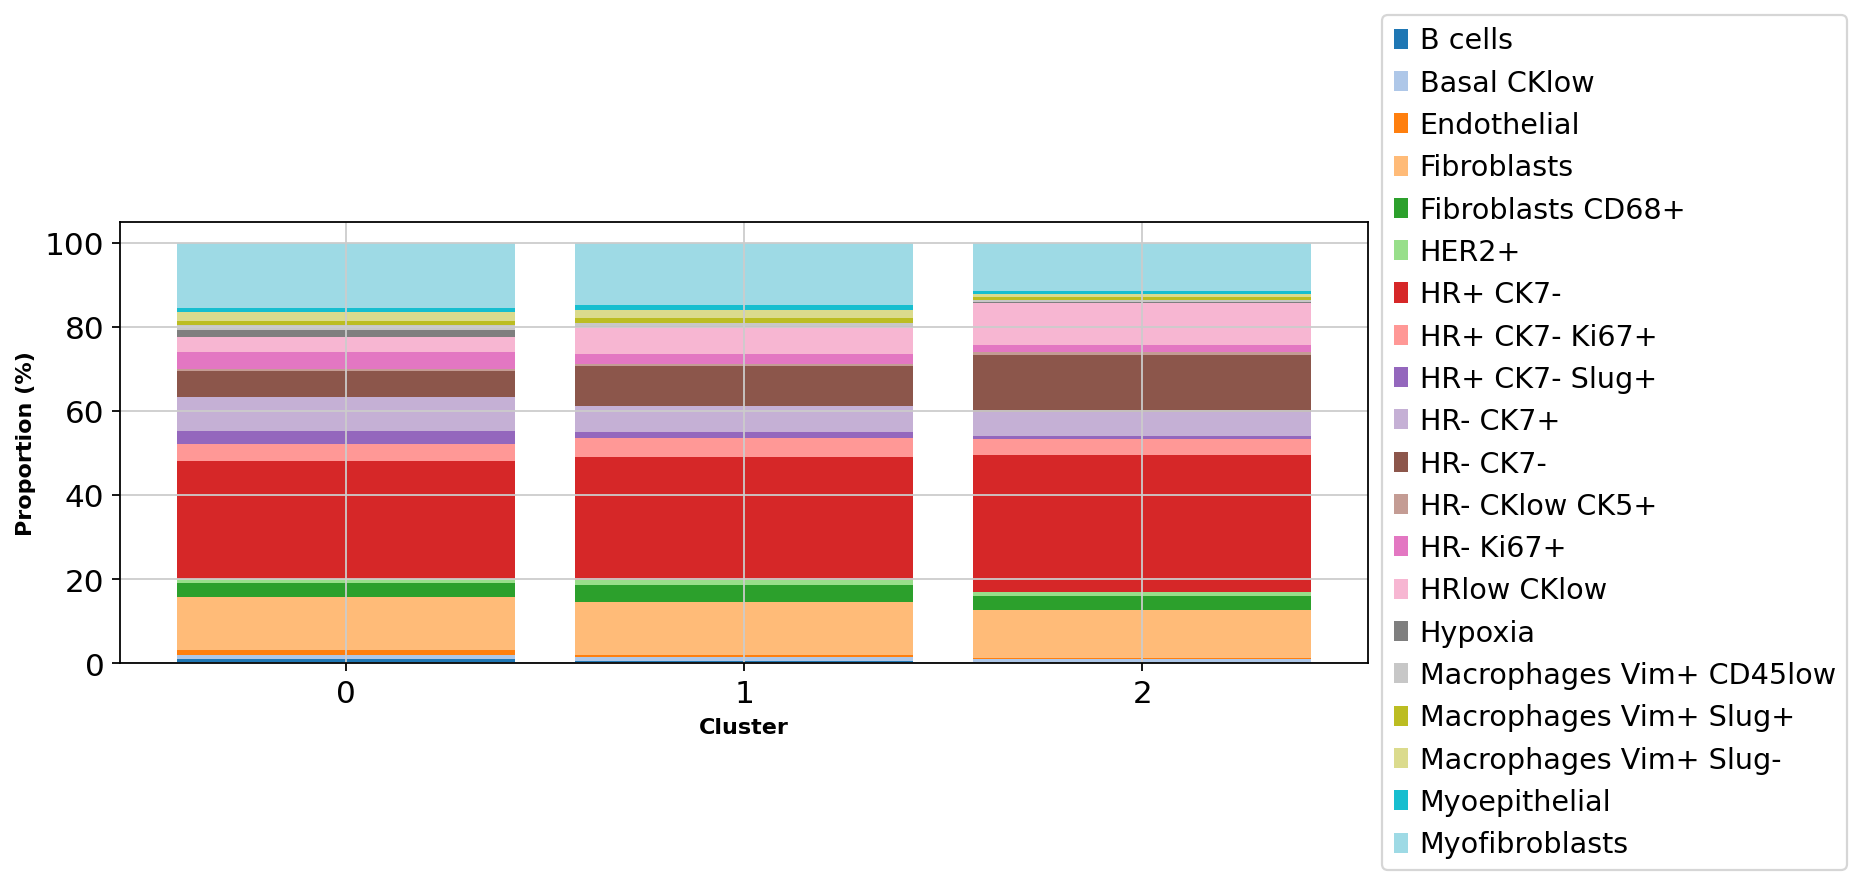

In [17]:
adata_exp.obs["leiden"] = adata_exp.obs["leiden"].astype("category")
# adata_exp[adata_exp.obs["importance_hard"]=="True",:]
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class")

# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class")
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "cell_type")

<h1>Clinical Subtype Analysis - Low vs. High Survivors</h1>

In [ ]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)

In [ ]:
embedding_arr = np.array(emd[0])
embedding_arr.shape
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst = [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade[0]))
    censor_lst.append(data.is_censored[0].item())

embedding_arr.shape
embedding_arr.shape[1]

In [ ]:
"""adata = ad.AnnData(embedding_arr)
adata.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata.obs_names = img_id_list
adata.obs["img_id"] = img_id_list
adata.obs["osmonth"] = osmonth_lst
adata.obs["p_id"] = pid_list
adata.obs["clinical_type"] = clinical_type_lst
adata.obs["tumor_grade"] = tumor_grade_lst"""
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

In [ ]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"



In [ ]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb, color=["osmonth", "leiden"], palette=color_dict, show=False, legend_loc = 'on data') #, save="_jacksonfisher_embedding_boxplot.pdf")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_umap.pdf"), dpi=300)


fig = plt.figure(figsize=(10, 5))
sns.boxplot(data=adata_emb.obs, x="leiden", y="osmonth", palette= color_dict)
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_boxplot.pdf"), dpi=300)
# sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
# sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
# sc.pl.umap(adata, color=["is_censored"], palette=["grey", "black"])

# sc.pl.dotplot(adata, n_genes=5, groupby='bulk_labels', dendrogram=True)

# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key=f"t-test", show=True, groupby=f"leiden")

In [ ]:
sc.tl.leiden(adata, key_added = "leiden")

In [ ]:
# sc.pl.umap(adata, color=["osmonth", "le"iden"])
upper_quartile = int(np.quantile(adata.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata.obs["osmonth"], 0.25))


adata.obs["high_surv"]="0"
adata.obs["low_surv"]="0"

adata.obs.loc[adata.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata.obs.loc[adata.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"

cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
sns.boxplot(data=adata.obs, x="leiden", y="osmonth", palette= color_dict)

In [ ]:
lower_quartile = int(np.quantile(adata.obs["osmonth"], 0.25))
adata_lower = adata[adata.obs["osmonth"]<lower_quartile,:].copy()

sc.tl.pca(adata_lower, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_lower)
sc.tl.umap(adata_lower)

sc.tl.leiden(adata_lower, resolution=1.0, key_added = "leiden_low_surv")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_lower, color=["osmonth", "tumor_grade", "clinical_type"])
sc.pl.umap(adata_lower, color="leiden_low_surv", palette=color_dict, legend_loc = 'on data')
sns.boxplot(data=adata_lower.obs, x="leiden_low_surv", y="osmonth", palette= color_dict)
# sc.pl.violin(adata_lower, 'osmonth', groupby='leiden', palette=color_dict)

In [ ]:
adata_clinical_subtype = adata[adata.obs["clinical_type"]=="HR+HER2-",:].copy()

"""
upper_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.25))


adata_clinical_subtype.obs["high_surv"]="0"
adata_clinical_subtype.obs["low_surv"]="0"

adata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"
"""


In [ ]:
sc.tl.pca(adata_clinical_subtype, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_clinical_subtype)
sc.tl.umap(adata_clinical_subtype)

sc.tl.leiden(adata_clinical_subtype, resolution=1.0, key_added = "leiden_HR+HER2-")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_clinical_subtype.obs["leiden_HR+HER2-"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_clinical_subtype, color=["osmonth", "tumor_grade", "clinical_type"])
sc.pl.umap(adata_clinical_subtype, color="leiden_HR+HER2-", palette=color_dict, legend_loc = 'on data')
sns.boxplot(data=adata_clinical_subtype.obs, x="leiden_HR+HER2-", y="osmonth")
sc.pl.umap(adata_clinical_subtype, color=["high_surv", "low_surv"])

In [ ]:
adata_exp = sc.read_h5ad("/net/data.isilon/ag-saez/bq_arifaioglu/home/Projects/GNNClinicalOutcomePrediction/data/out_data/adatafiles/METABRIC_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

In [ ]:
adata_exp.obs

In [ ]:
pdata = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

pdata

In [ ]:
sc.tl.rank_genes_groups(pdata, 'importance_hard', method='t-test')
sc.pl.rank_genes_groups(pdata, n_genes=10, sharey=False)

In [ ]:
print(adata_exp.X.shape)
print(adata_exp.X[~np.isnan(adata_exp.X).any(axis=1)].shape)

print(pdata.X.shape)
print(pdata.X[~np.isnan(pdata.X).any(axis=1)].shape)